In [71]:
import numpy as np
import shapefile
import shapely
import shapely.geometry
from tqdm import tqdm
import pyproj

## Census regions

In [9]:
file = shapefile.Reader("data/SP_Setores_2021/SP_Setores_2021.shp")
new_file = shapefile.Writer("data/SP_Setores_2021/sp.shp")
new_file.fields = file.fields[1:]

In [12]:
for shape in file.shapeRecords():
    fields = dict(zip([field[0] for field in file.fields[1:]], shape.record))
    if fields["NM_MUN"] == "São Paulo":
        new_file.record(*shape.record)
        new_file.shape(shape.shape)

In [14]:
new_file.close()

In [17]:
file = shapefile.Reader("data/SP_Setores_2021/sp.shp")
print(file.numRecords)

55184


In [18]:
# concat all the shapes
shapes = [shapely.geometry.shape(shape) for shape in file.shapes()]
union = shapes[0]
for shape in shapes[1:]:
    union = union.union(shape)

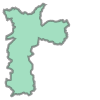

In [19]:
union

## Districts

In [95]:
file = shapefile.Reader("data/LAYER_DISTRITO/DEINFO_DISTRITO.shp")
new_file = shapefile.Writer("data/LAYER_DISTRITO/sp.shp")
new_file.fields = file.fields[1:]

In [96]:
origin = pyproj.Proj("EPSG:29193")
target = pyproj.Proj("EPSG:4326")
def transform(x, y):
    return pyproj.transform(origin, target, x, y)

for shape in tqdm(file.shapeRecords()):
    old_shape = shapely.geometry.shape(shape.shape)
    old_coords = np.array(old_shape.exterior.coords)
    new_coords = transform(old_coords[:, 0], old_coords[:, 1])
    new_shape = shapely.geometry.Polygon(zip(new_coords[1], new_coords[0]))
    
    new_file.record(*shape.record)
    new_file.shape(new_shape)

    

  0%|          | 0/96 [00:00<?, ?it/s]

/tmp/ipykernel_4626/1076305810.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(origin, target, x, y)
100%|██████████| 96/96 [00:02<00:00, 38.01it/s]


In [97]:
new_file.close()

In [102]:
file = shapefile.Reader("data/LAYER_DISTRITO/sp.shp")
# create union
shapes = [shapely.geometry.shape(shape) for shape in file.shapes()]
union = shapes[0]
for shape in shapes[1:]:
    union = union.union(shape)
print("Nº polygons:", len(shapes))
union = union.buffer(0.01)
#union = union.simplify(0.01)

Nº polygons: 96


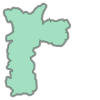

In [103]:
union

In [104]:
# save contour to geojson
with open("data/countour.geojson", "w") as f:
    f.write(shapely.to_geojson(union))
    